In [2]:
# Import necessary packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np


In [3]:
# Load the data 

dunking_data = pd.read_csv('data/dunking-data.csv')
microscopy_data = pd.read_csv('data/microscopy-data.csv')
tr1_data = pd.read_csv('data/tr-1.csv')
tr2_data = pd.read_csv('data/tr-2.csv')
tr3_data = pd.read_csv('data/tr-3.csv')

# Constants
tea_surface_tension = 6.78e-2  # N m−1
contact_angle = 1.45  # rad
tea_dynamic_viscosity = 9.93e-4  # Pa s

tr1_data['eta'] = tea_dynamic_viscosity
tr1_data['gamma'] = tea_surface_tension
tr1_data['phi'] = contact_angle

tr2_data['eta'] = tea_dynamic_viscosity
tr2_data['gamma'] = tea_surface_tension
tr2_data['phi'] = contact_angle

tr3_data['eta'] = tea_dynamic_viscosity
tr3_data['gamma'] = tea_surface_tension
tr3_data['phi'] = contact_angle

In [4]:
# Take out labels
dunking_data_unlabeled = dunking_data.drop(columns=['biscuit'])

# Standardize data 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extract column and row names 
dunking_data_cols = dunking_data_unlabeled.columns
dunking_data_indexes = dunking_data_unlabeled.index

# Standardise the data with a mean of ~0 and variance of 1 
stdX = StandardScaler().fit_transform(dunking_data_unlabeled)
stdX_df = pd.DataFrame(stdX, columns=dunking_data_cols)

In [5]:
# Creating PCA instance for analysis of num_components hyperparam
num_components = 5
pca_model = PCA(num_components)
pca = pca_model.fit_transform(stdX)
pca_df = pd.DataFrame(pca)

## Creating dataframe with pca components and explained 
PCA_components = pd.DataFrame(pca_model.components_, columns = dunking_data_cols)
PCA_components = PCA_components.transpose()*np.sqrt(pca_model.explained_variance_)
PCA_components.columns = [f'PC{i}' for i in list(range(1, num_components+1))]
PCA_components.loc['Eigenvalues'] = pca_model.explained_variance_
PCA_components.loc['Tot. var / %'] = pca_model.explained_variance_ratio_*100
PCA_components.loc['Tot. Cumulative var / %'] = np.cumsum(PCA_components.loc['Tot. var / %'])
display(PCA_components)

,PC1,PC2,PC3,PC4,PC5
gamma,0.165034,0.353687,0.738646,-0.548124,0.044326
phi,-0.892733,0.263541,-0.104272,-0.246979,-0.249072
eta,-0.011969,-0.754825,-0.144469,-0.639954,-0.004182
L,0.963271,0.006236,-0.010044,-0.002416,-0.268882
t,0.312685,0.517644,-0.662146,-0.432894,0.093661
Eigenvalues,1.850013,1.032303,1.015880,0.958382,0.145089
Tot. var / %,36.987929,20.639170,20.310831,19.161252,2.900817
Tot. Cumulative var / %,36.987929,57.627099,77.937930,97.099183,100.000000


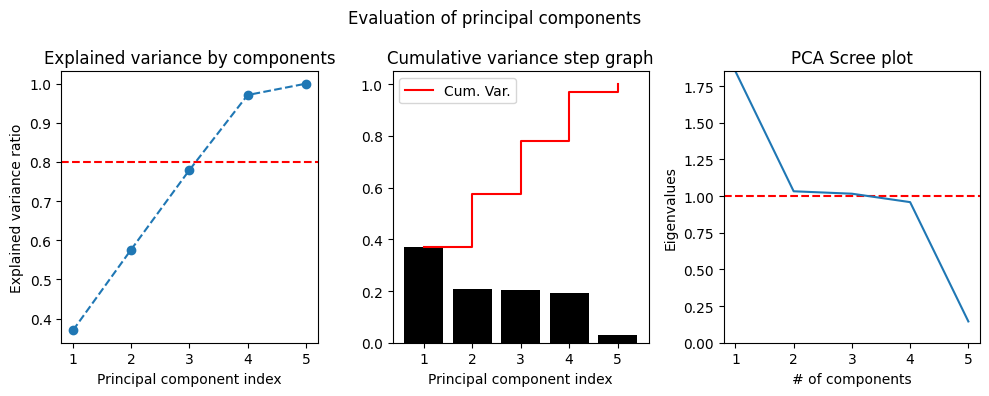

In [6]:
# Scree and Cumulative variance plots
fig, axs = plt.subplots(1,3, figsize = (10,4), sharey = False)


axs[0].plot(range(1,num_components+1), pca_model.explained_variance_ratio_.cumsum(), marker = "o", linestyle = "--")
axs[0].axhline(y=0.8,color = "r" , linestyle = "--")
axs[0].set_title("Explained variance by components")
axs[0].set_ylabel('Explained variance ratio')
axs[0].set_xlabel('Principal component index')

axs[1].bar(range(1,num_components+1), pca_model.explained_variance_ratio_, color='black')
axs[1].step(range(1,num_components+1), pca_model.explained_variance_ratio_.cumsum(), where='post',label='Cum. Var.', color= "r")
#axs[1].set_ylabel('Explained variance ratio')
axs[1].set_xlabel('Principal component index')
axs[1].set_title("Cumulative variance step graph")
axs[1].legend(loc="upper left")

axs[2].set_ylabel("Eigenvalues")
axs[2].set_xlabel("# of components")
axs[2].set_title("PCA Scree plot")
axs[2].set_ylim(0,max(pca_model.explained_variance_))
axs[2].axhline(y=1,color = "r" , linestyle = "--")
axs[2].plot(range(1,num_components+1), pca_model.explained_variance_)

fig.suptitle("Evaluation of principal components")
fig.tight_layout()
plt.show()

In [7]:
# Creating 4PC PCA instance  

num_components = 4
pca_model = PCA(num_components)
pca = pca_model.fit_transform(stdX)
pca_df = pd.DataFrame(pca)

## Creating dataframe with pca components and explained 
PCA_components = pd.DataFrame(pca_model.components_, columns = dunking_data_cols)
PCA_components = PCA_components.transpose()*np.sqrt(pca_model.explained_variance_)
PCA_components.columns = [f'PC{i}' for i in list(range(1, num_components+1))]
PCA_components.loc['Eigenvalues'] = pca_model.explained_variance_
PCA_components.loc['Tot. var / %'] = pca_model.explained_variance_ratio_*100
PCA_components.loc['Tot. Cumulative var / %'] = np.cumsum(PCA_components.loc['Tot. var / %'])

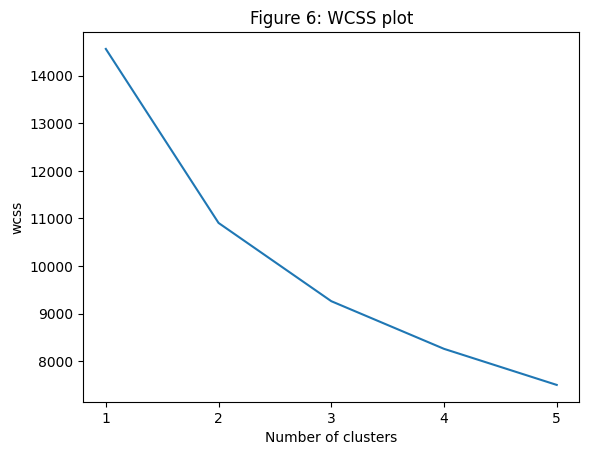

In [11]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import normalize

# Evaluating number of clusters for kmeans 
wcss = []
wcss_dbscan = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init="auto", random_state = 10)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(pca)
    kmeans.fit(pca)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

# Plotting wcss     
plt.title("Figure 6: WCSS plot")
plt.xlabel("Number of clusters")
plt.ylabel("wcss")
x=np.arange(1,len(wcss)+1,1)
plt.plot(x, wcss)
plt.xticks(x)
plt.show()



For n_clusters = 2 The average silhouette_score is : 0.2389450487848022
For n_clusters = 3 The average silhouette_score is : 0.20309892651273947
For n_clusters = 4 The average silhouette_score is : 0.19002608628435178
For n_clusters = 5 The average silhouette_score is : 0.18835868295553526


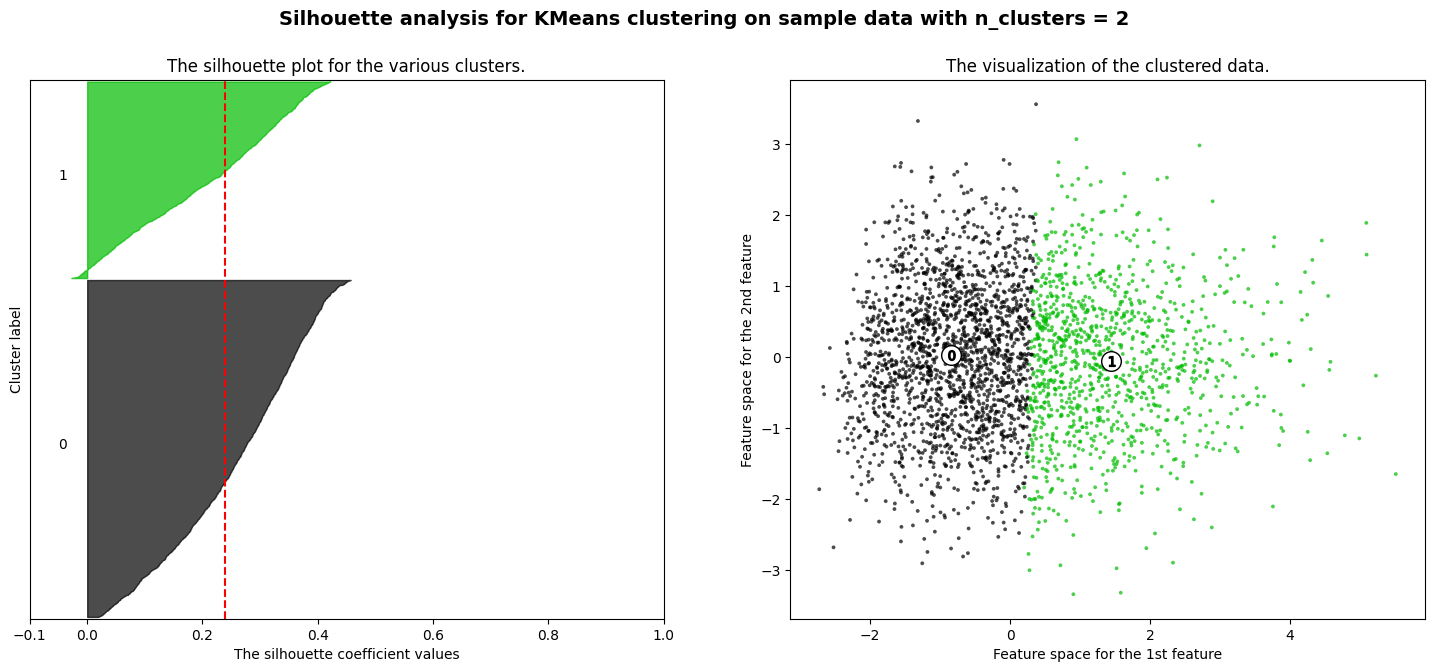

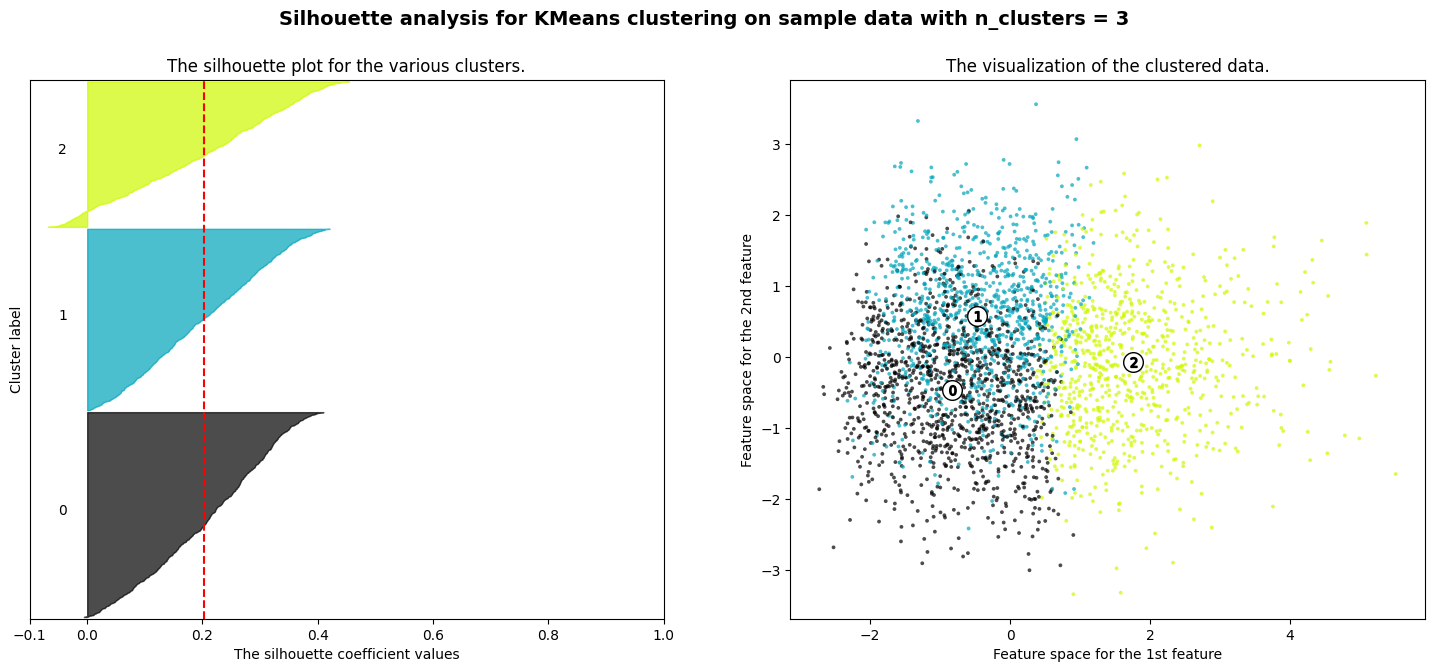

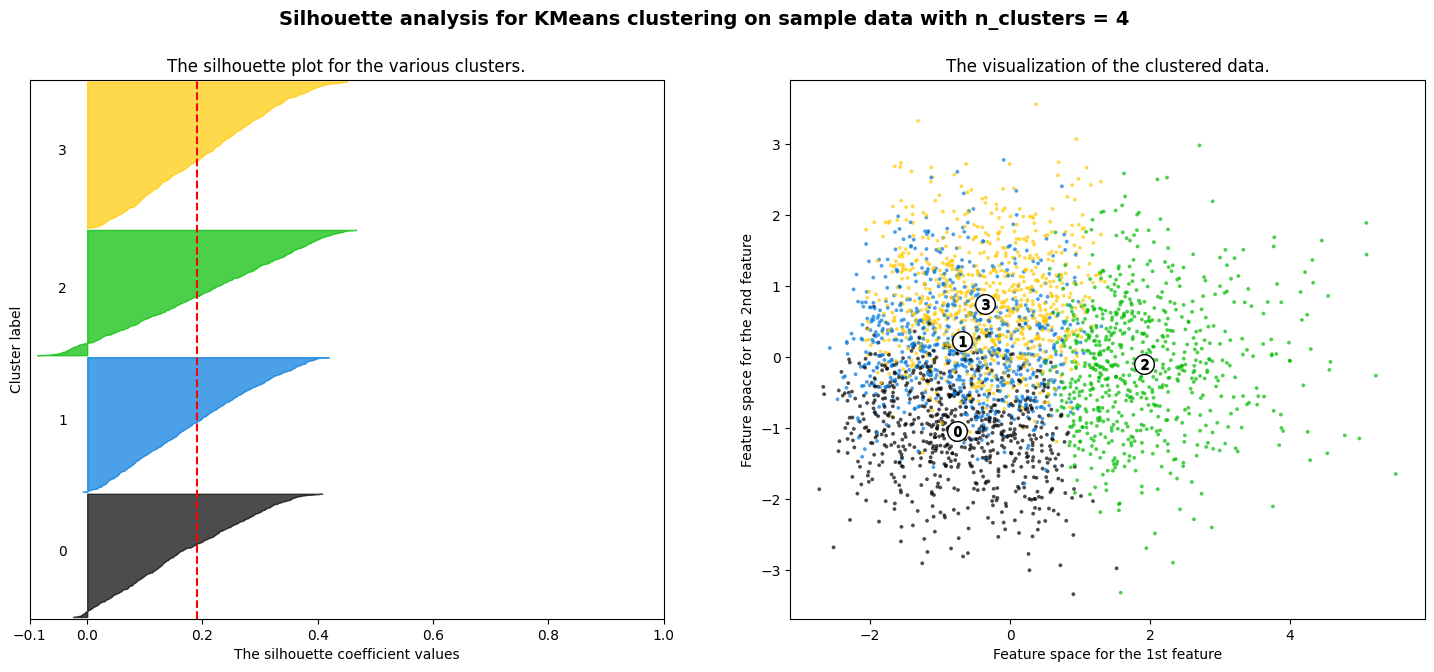

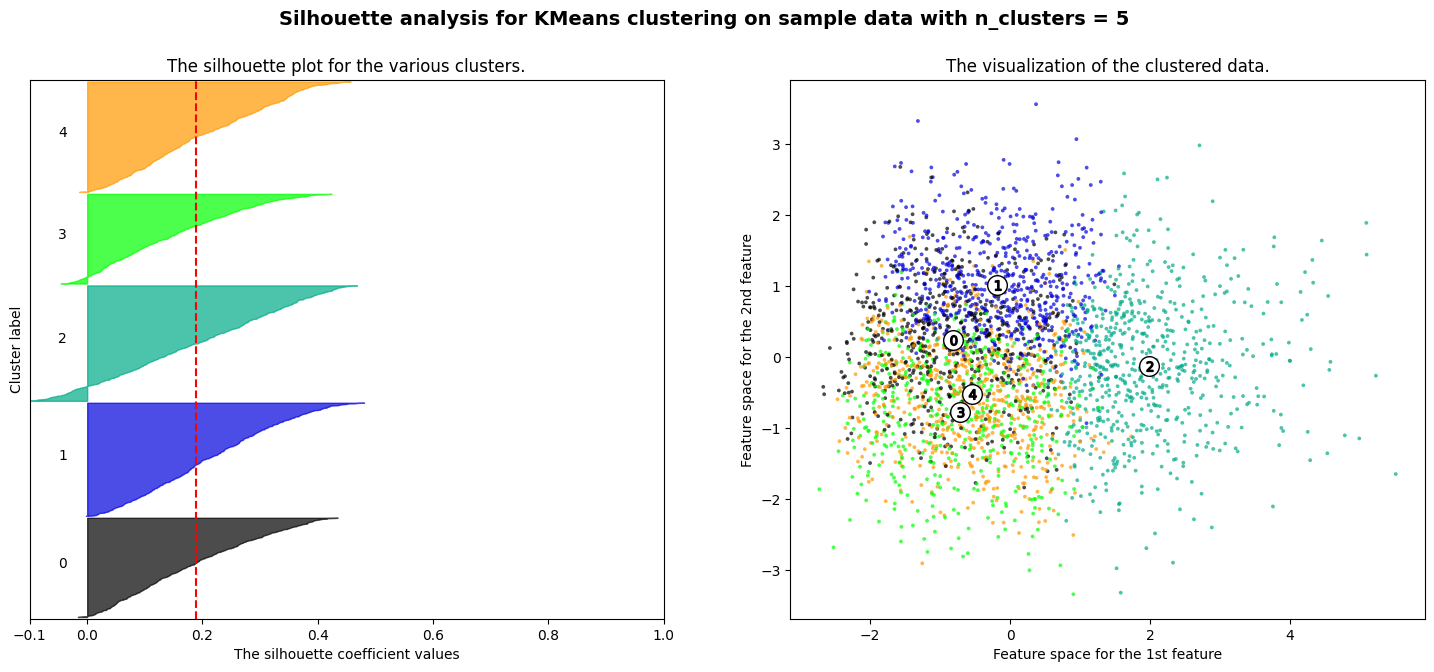

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2,3,4, 5]
silhouette_values = list()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters = n_clusters, max_iter=1000,init = 'k-means++', n_init="auto", random_state = 10)
    cluster_labels = kmeans.fit_predict(pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    #Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca, cluster_labels)
    silhouette_values.append(silhouette_avg)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        pca[:, 0], pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

biscuit  Digestive  Hobnob  Rich Tea
kmeans                              
0              314     411       431
1              312     335       377
2              374     254       192
biscuit  Digestive  Hobnob  Rich Tea
row_0                               
-1             250     199       175
 0             679     749       769
 1               2       0         1
 2               1       1         3
 3               1       1         1
 4               0       3         1
 5               2       1         0
 6               0       5         2
 7               2       0         2
 8               2       0         1
 9               3       0         0
 10              5       3         3
 11              3       3         4
 12              1       1         1
 13              0       2         2
 14              1       4         1
 15              1       4         0
 16              2       1         0
 17              4       1         0
 18              1       3         3
 

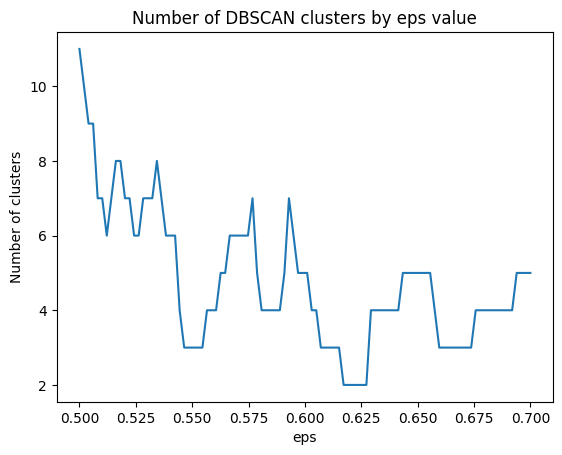

In [23]:
## Clustering (unsupervised learning)
# kmeans and cosine distance kmeans

n_clusters = 3

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
kmeans = KMeans(n_clusters = n_clusters, max_iter=1000,init = 'k-means++',n_init="auto", random_state = 10)
cluster_labels = kmeans.fit_predict(pca)
dunking_data_unlabeled["kmeans"] = cluster_labels

u_cluster_labels = np.unique(cluster_labels)

# Compare cluster labels to biscuit type
cluster_biscuit_crosstab = pd.crosstab(dunking_data_unlabeled["kmeans"], dunking_data["biscuit"])
print(cluster_biscuit_crosstab)


dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(pca)

cluster_biscuit_crosstab_dbscan = pd.crosstab(dbscan.labels_, dunking_data["biscuit"])
print(cluster_biscuit_crosstab_dbscan)

import matplotlib.pyplot as plt

eps_values = np.linspace(0.5, 0.7, 100)
num_clusters = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan_labels = dbscan.fit_predict(pca)
    num_clusters.append(len(np.unique(dbscan_labels)))

plt.plot(eps_values, num_clusters)
plt.xlabel('eps')
plt.ylabel('Number of clusters')
plt.title('Number of DBSCAN clusters by eps value')
plt.show()


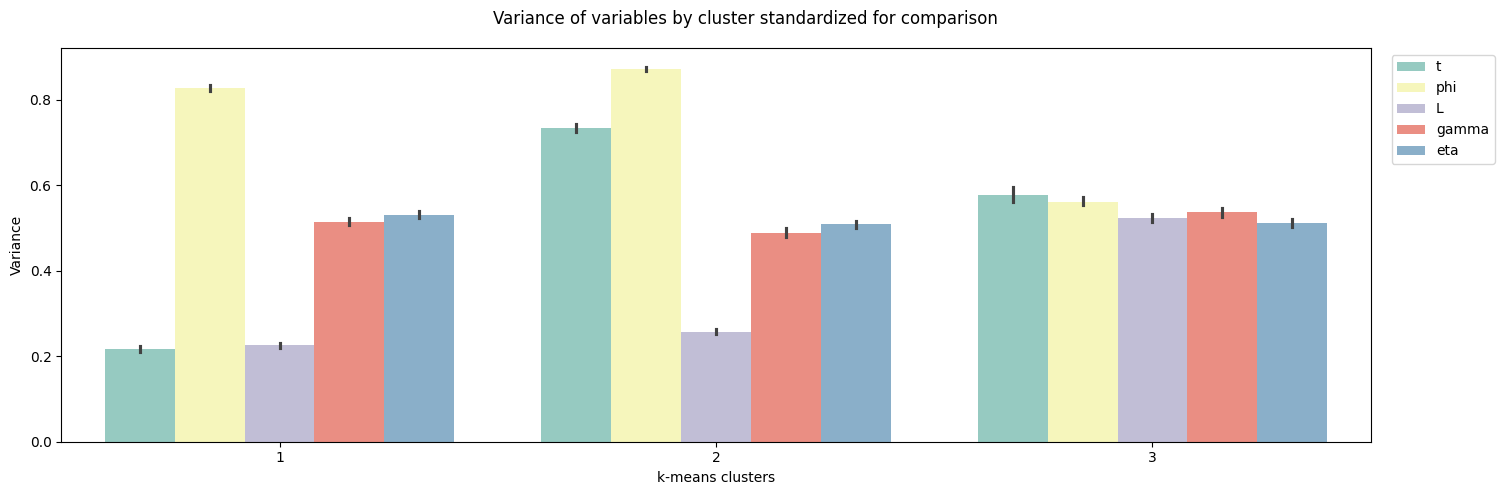

In [35]:
# Visualizing variance in each cluster 
from sklearn.preprocessing import MinMaxScaler

# Setting all variables between 0 and 1 in order to better visualize the results
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(dunking_data_unlabeled))
data_scaled.columns = dunking_data_unlabeled.columns

# Calculate variables with largest differences (by standard deviation)
# The higher the standard deviation in a variable based on average values for each cluster
# The more likely that the variable is important when creating the cluster
data_mean = data_scaled.groupby('kmeans').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in data_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(data_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).Variable.values) + ['kmeans']

# Plot data
tidy = data_scaled[selected_columns].melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right',bbox_to_anchor = [1.1,1])
plt.suptitle("Variance of variables by cluster standardized for comparison")
plt.tight_layout()
ax.set_xlabel("k-means clusters")
ax.set_ylabel("Variance")
ax.set_xticks([0,1,2],[1,2,3])
plt.show()